In [1]:
import os
import sys
from tqdm.notebook import tqdm
from IPython.display import clear_output

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
from MatSamp import *
import matplotlib.pyplot as plt
import igraph as ig
import networkx as nx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle

plt.rcParams.update(
    {"text.usetex": True, "font.family": "STIXGeneral", "mathtext.fontset": "stix"}
)

visual_style = {
    "vertex_size": 5,
    "vertex_color": "white",
    "vertex_frame_width": 1,
    "edge_width": 0.5,
    "bbox": (400, 400),  # Size of the plot canvas
    "margin": 20,
    "vertex_label_color": "black",
}

In [3]:
n = 1024
p = np.round(1.1 * np.log(n) / n, 2)
# print(n, p)
net = ig.Graph.Erdos_Renyi(n=n, p=p)
# net = ig.Graph.K_Regular(n=n, k=4)

In [4]:
A = ig_to_A(net)
SNet = MatSamp(A, False)
deg = SNet.deg
n = SNet.n


In [5]:
sample_num = 1000000
beta = 1e9


In [6]:
samples_nb_swap = []
samples_cb_swt = []

In [7]:
# sample = 0
A = ig_to_A(net)
SNet = MatSamp(A, False)
SNet.trackCheckerboard = True

for i in tqdm(range(sample_num)):
    swt = SNet.next("rand")

    rcur = SNet.assortativity_coeff()
    SNet.switch(swt)
    rnxt = SNet.assortativity_coeff()

    if np.log(np.random.rand()) > beta*(rcur-rnxt):
        SNet.switch(swt)

    ps, ns = SNet.count_checker()
    samples_nb_swap.append((SNet.assortativity_coeff(),(ns-ps)/(ps+ns)))

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
A = ig_to_A(net)
SNet = MatSamp(A, False)
SNet.trackCheckerboard = True

for i in tqdm(range(sample_num)):
    pscur, nscur = SNet.count_checker()
    rcur = SNet.assortativity_coeff()

    if pscur == 0:
        rho_cur = 0
        posswt = False
    elif nscur == 0:
        rho_cur = 1
        posswt = True
    else:
        rho_cur = 0.5
        # rho_cur = (kappa / 2 - qcur) / kappa
        p_posswt = np.random.rand()
        posswt = p_posswt < rho_cur

    swt = find_random_checker(
        SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, posswt
    )

    SNet.switch(swt)
    rnxt = SNet.assortativity_coeff()
    psnxt, nsnxt = SNet.count_checker()

    if psnxt == 0:
        rho_nxt = 0
    elif nsnxt == 0:
        rho_nxt = 1
    else:
        rho_nxt = 0.5

    gcur = np.log((rho_cur / pscur if posswt else (1 - rho_cur) / nscur))
    gnxt = np.log(((1 - rho_nxt) / nsnxt if posswt else rho_nxt / psnxt))

    # switch back
    if np.log(np.random.rand()) > beta*(rcur-rnxt) + gnxt - gcur:
        SNet.switch(swt)

    ps, ns = SNet.count_checker()
    samples_cb_swt.append((SNet.assortativity_coeff(),(ns-ps)/(ps+ns)))

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

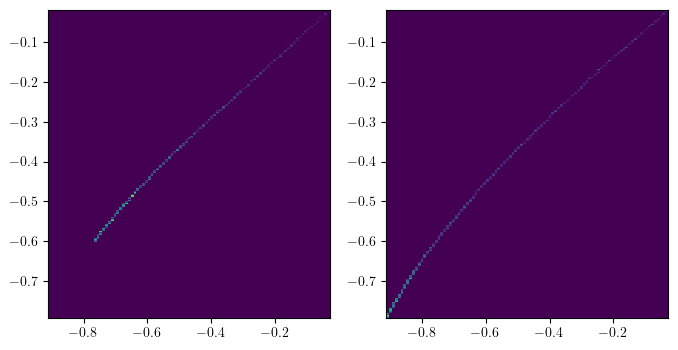

In [10]:
fig, ax = plt.subplots(1, 2,figsize = (8,4))
x1 = [i[0] for i in samples_nb_swap]
y1 = [i[1] for i in samples_nb_swap]

x2 = [i[0] for i in samples_cb_swt]
y2 = [i[1] for i in samples_cb_swt]

binx = np.linspace(min(x1+x2), max(x1+x2), 100)
biny = np.linspace(min(y1+y2), max(y1+y2), 1000)
# plt.subplots(2,1)
ax[0].hist2d(x1, y1, bins=(binx, biny));
ax[1].hist2d(x2, y2, bins=(binx, biny));